<a href="https://colab.research.google.com/github/DreamnVibes/LandCover_Classification/blob/main/Land_Cover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**A comparative analysis of performance of CNN vs ResNET for a land cover classification dataset**

In [13]:
#Load  and extract uc merced landuse dataset by abdul hasib uddin
"""This is a 21 class land use image dataset meant for research purposes published by the user: Abdul Hasib Uddin on Kaggle
There are 100 images for each class.
Each image measures 256x256 pixels.

The images were manually extracted from large images from the USGS National Map Urban Area Imagery collection
for various urban areas around the country. The pixel resolution of this public domain imagery is 1 foot.

cite: Yi Yang and Shawn Newsam, "Bag-Of-Visual-Words and Spatial Extensions for Land-Use Classification," ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems (ACM GIS), 2010.

"""
import zipfile
import os

zipped_pth = "/content/ucmerced.zip"
extrcted_pth = "/content/ucmerced"

if not os.path.exists(extrcted_pth):
    with zipfile.ZipFile(zipped_pth, 'r') as zip_ref:
        zip_ref.extractall(extrcted_pth)

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [3]:
#Listing categories
import os
cat = os.listdir(extrcted_pth + '/UCMerced_LandUse/Images')
print(f"Total categories: {len(cat)}")
print("Categories:", cat)

Total categories: 21
Categories: ['airplane', 'forest', 'mobilehomepark', 'parkinglot', 'storagetanks', 'runway', 'overpass', 'golfcourse', 'mediumresidential', 'chaparral', 'harbor', 'tenniscourt', 'buildings', 'freeway', 'river', 'sparseresidential', 'beach', 'baseballdiamond', 'denseresidential', 'intersection', 'agricultural']


In [4]:
#Apply transformations and define data loaders
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=extrcted_pth + '/UCMerced_LandUse/Images', transform=transform)

train_sz = int(0.7 * len(dataset))
val_sz = int(0.15 * len(dataset))
test_sz = len(dataset) - train_sz - val_sz

train_data, val_data, test_data = random_split(dataset, [train_sz, val_sz, test_sz])

batch_sz = 32
train_ld = DataLoader(train_data, batch_size=batch_sz, shuffle=True)
val_ld = DataLoader(val_data, batch_size=batch_sz, shuffle=False)
test_ld = DataLoader(test_data, batch_size=batch_sz, shuffle=False)


In [5]:
#define custom cnn
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=21):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 128 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
#load ResNET model
from torchvision import models

def get_resnet_model(num_classes=21):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [7]:
#training and evaluate
import matplotlib.pyplot as plt

def train(model, train_ld, val_ld, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    critrn = nn.CrossEntropyLoss()

    train_acc_list = []
    val_acc_list = []

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0

        for inputs, labels in train_ld:
            inputs, labels = inputs.to(device), labels.to(device)
            opt.zero_grad()
            outputs = model(inputs)
            loss = critrn(outputs, labels)
            loss.backward()
            opt.step()
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        val_acc = evaluate_model(model, val_ld)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    return train_acc_list, val_acc_list

def evaluate_model(model, ld):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in ld:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


In [8]:
#train both models
cnn_model = SimpleCNN(num_classes=21)
print("Training Simple CNN...")
cnn_train_acc, cnn_val_acc = train(cnn_model, train_ld, val_ld, epochs=10)

rsnt = get_resnet_model(num_classes=21)
print("Training ResNet18...")
rsnt_train_acc, rsnt_val_acc = train(rsnt, train_ld, val_ld, epochs=10)

Training Simple CNN...
Epoch [1/10] Loss: 174.4580, Train Acc: 5.58% | Val Acc: 8.89%
Epoch [2/10] Loss: 118.5711, Train Acc: 21.70% | Val Acc: 27.62%
Epoch [3/10] Loss: 83.3700, Train Acc: 47.69% | Val Acc: 40.63%
Epoch [4/10] Loss: 46.6253, Train Acc: 70.95% | Val Acc: 40.95%
Epoch [5/10] Loss: 24.0375, Train Acc: 86.12% | Val Acc: 41.27%
Epoch [6/10] Loss: 11.9362, Train Acc: 94.35% | Val Acc: 44.76%
Epoch [7/10] Loss: 9.0851, Train Acc: 94.63% | Val Acc: 42.22%
Epoch [8/10] Loss: 6.8353, Train Acc: 96.73% | Val Acc: 40.95%
Epoch [9/10] Loss: 4.4766, Train Acc: 97.41% | Val Acc: 42.86%
Epoch [10/10] Loss: 2.7836, Train Acc: 98.57% | Val Acc: 44.76%


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


Training ResNet18...
Epoch [1/10] Loss: 49.5546, Train Acc: 67.96% | Val Acc: 78.10%
Epoch [2/10] Loss: 22.5001, Train Acc: 83.95% | Val Acc: 54.92%
Epoch [3/10] Loss: 13.9615, Train Acc: 91.22% | Val Acc: 79.68%
Epoch [4/10] Loss: 12.0291, Train Acc: 91.63% | Val Acc: 83.49%
Epoch [5/10] Loss: 7.2997, Train Acc: 95.24% | Val Acc: 80.32%
Epoch [6/10] Loss: 8.0667, Train Acc: 95.03% | Val Acc: 79.37%
Epoch [7/10] Loss: 4.1669, Train Acc: 97.21% | Val Acc: 89.84%
Epoch [8/10] Loss: 2.9828, Train Acc: 98.64% | Val Acc: 91.11%
Epoch [9/10] Loss: 3.9252, Train Acc: 97.69% | Val Acc: 90.79%
Epoch [10/10] Loss: 4.4028, Train Acc: 97.28% | Val Acc: 88.57%


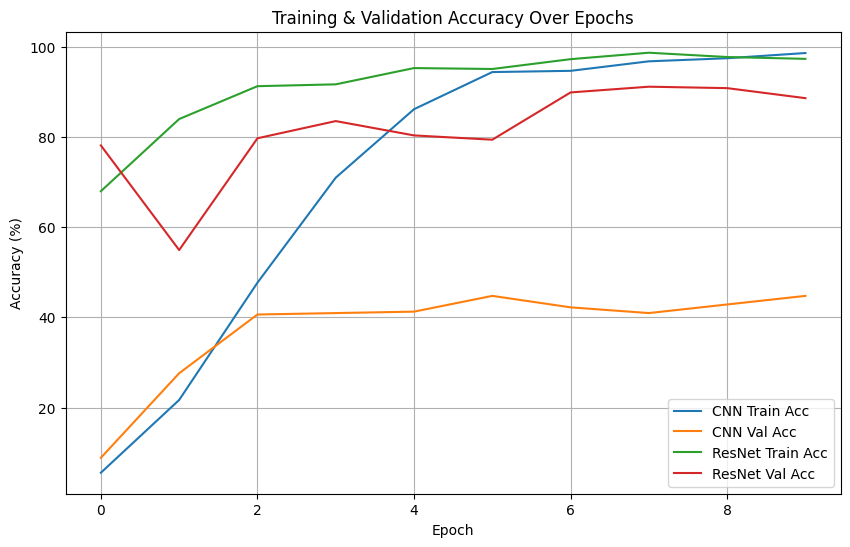

In [9]:
#Plot accuracy curves for both models
plt.figure(figsize=(10, 6))
plt.plot(cnn_train_acc, label='CNN Train Acc')
plt.plot(cnn_val_acc, label='CNN Val Acc')
plt.plot(rsnt_train_acc, label='ResNet Train Acc')
plt.plot(rsnt_val_acc, label='ResNet Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
#Evaluate test accuracy for both models
print("Testing Simple CNN...")
cnn_test_acc = evaluate_model(cnn_model, test_ld)
print(f"Test Accuracy (Simple CNN): {cnn_test_acc:.2f}%")

print("Testing ResNet18...")
rsnt_test_acc = evaluate_model(rsnt, test_ld)
print(f"Test Accuracy (ResNet18): {rsnt_test_acc:.2f}%")

Testing Simple CNN...
Test Accuracy (Simple CNN): 47.62%
Testing ResNet18...
Test Accuracy (ResNet18): 88.89%


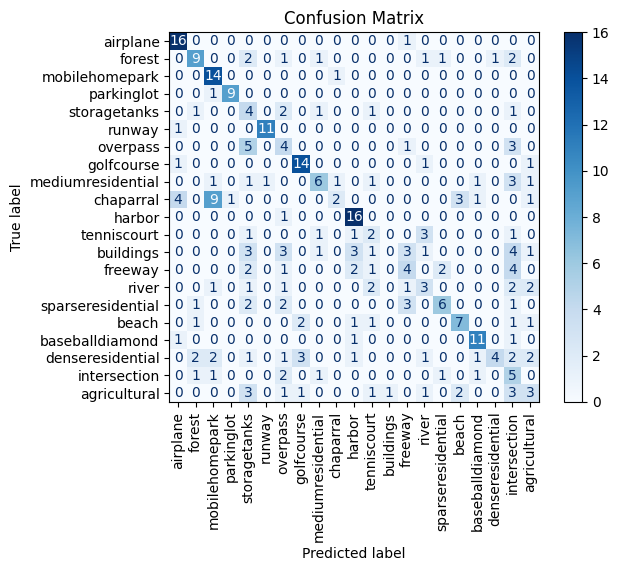

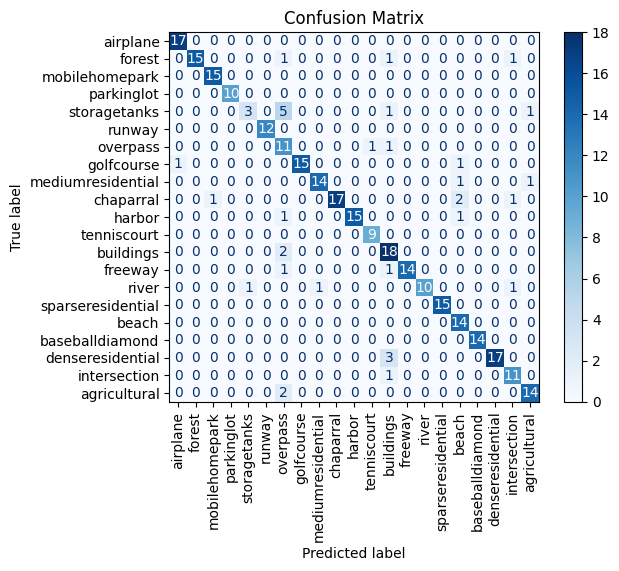

In [11]:
#Display confusion matrices
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, loader, class_names):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation='vertical', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(cnn_model, test_ld, class_names=cat)
plot_confusion_matrix(rsnt, test_ld, class_names=cat)

Example Predictions (Simple CNN):


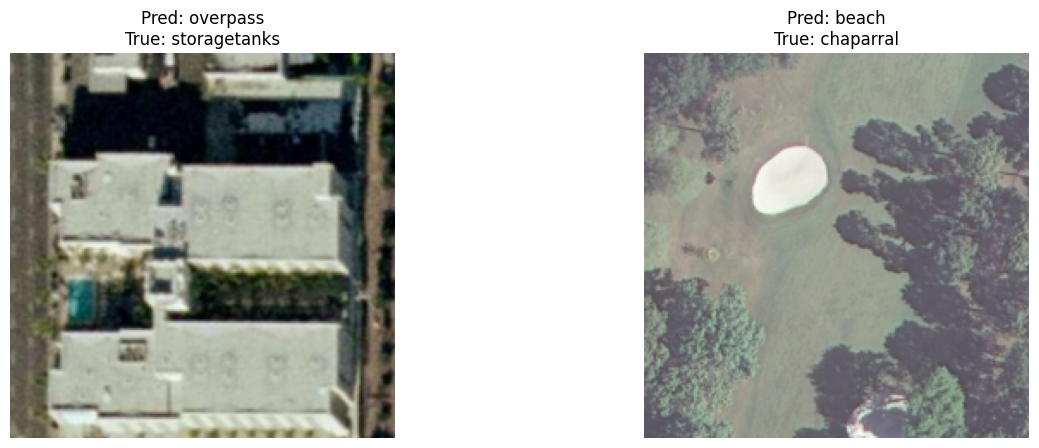

Example Predictions (ResNet18):


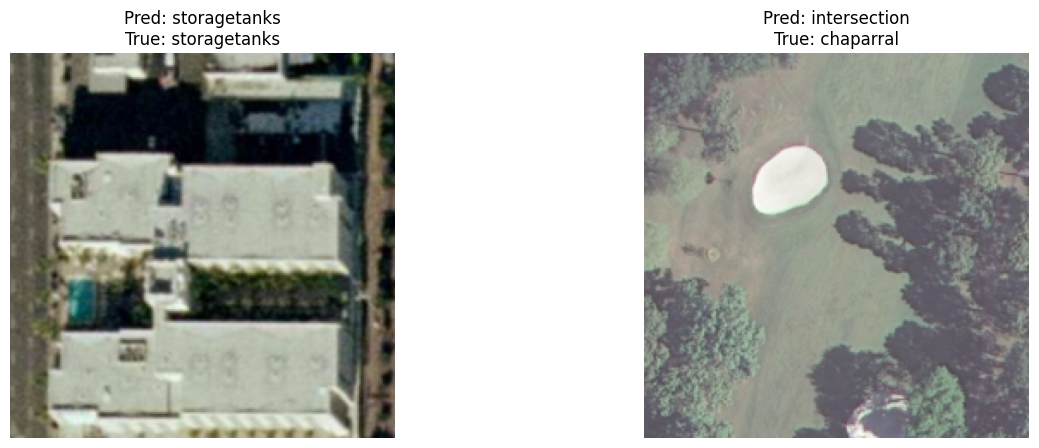

In [12]:
#Example predictions
def predict_and_show_examples(model, loader, class_names, num_images=2):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    images_shown = 0
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if images_shown >= num_images:
                    break
                img = inputs[i].cpu().permute(1, 2, 0).numpy()
                axes[images_shown].imshow(img)
                axes[images_shown].set_title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
                axes[images_shown].axis('off')
                images_shown += 1
            if images_shown >= num_images:
                break
    plt.show()

print("Example Predictions (Simple CNN):")
predict_and_show_examples(cnn_model, test_ld, cat)

print("Example Predictions (ResNet18):")
predict_and_show_examples(rsnt, test_ld, cat)

Through the test set evaluations (CNN: 47.62% and ResNET: 88.89%), the overwhelming advantage ResNET has over CNN in the form of residual networks and layer skipping is apparent. By having gradients skip layers during backpropagation, ResNET eliminates the problem of vanishing gradients, allowing the models to learn and remember features more efficiently.

For the CNN model, training accuracy is good but validation accuracy stagnates. This points to CNN underfitting the dataset, while ResNET displays good accuracy in both training and validation, indicating good learning and generalization.